# Mobile Service (research)

Aleksandr Dunaev  
09.02.2023

version: 1.0

## 1 Описание задачи

__Задача__

У нас появился запрос из отдела продаж и маркетинга. Оператор сотовой связи предлагает обширный набор различных услуг своим абонентам. При этом, разным пользователям интересны разные услуги. Поэтому, необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.  

__Данные__  

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяца, а на test отложен последующий месяц.  

Итого, в качестве входных данных будут представлены:  

●	data_train.csv: id, vas_id, buy_time, target;  
●	features.csv.zip: id, <feature_list>.  


И тестовый набор:  

●	data_test.csv: id, vas_id, buy_time;  
●	target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно;  
●	buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime;  
●	id - идентификатор абонента;  
●	vas_id - подключаемая услуга.  


Примечание: Размер файла features.csv в распакованном виде весит 20 Гб, для работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.  

__Метрика__  

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

## 2 Подключение и настройка внешних модулей

In [1]:
# data processing
import pandas as pd
import numpy as np
import dask.dataframe as dd
import sklearn
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# сериализация объектов
import pickle

## 3 Загрузка датасетов

In [2]:
df_train = pd.read_csv(r'data/data_train.csv')
df_test = pd.read_csv(r'data/data_test.csv')
df_features = dd.read_csv(r'data/features.csv', sep='\t', engine='python')

## 4 Предварительная обработка данных

### Вспомогательные структуры

In [3]:
def data_frame_missing_values(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage."""

    total = df.isnull().sum().sort_values(ascending=False)
    percent = round(df.isnull().sum().sort_values(ascending=False) / len(df) * 100, 2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [4]:
def distribution_diagram(data, feature_name, hue=False, is_log=False, is_label=True):
    """Построение диаграммы распределения."""

    fig = plt.figure(figsize=(12, 8), layout='constrained')
    countplot = sns.countplot(data=data, x=feature_name, color='#a1c9f4', log=is_log) 
    
    if hue:
        countplot = sns.countplot(data=data, x=feature_name, hue=hue, palette=['#ff9f9b', '#8de5a1'], log=is_log)
        countplot.set(title=f'Диграмма распределения признака {feature_name} в разрезе признака {hue}')
    
    else:
        countplot.set(title=f'Диграмма распределения признака {feature_name}')
        
    if is_label:
        for container in countplot.containers:
            countplot.bar_label(container)

    plt.show()

In [5]:
def feature_transformer(dataset, source_list, feature_name, transformer, prefitting=True):
    """Трансформация признаков."""

    # prefitting
    if prefitting:
        transformer.fit(dataset[source_list])

    # transforming
    if type(transformer) == sklearn.preprocessing._encoders.OneHotEncoder:

        df_OHE = pd.DataFrame(
            transformer.transform(dataset[source_list]),
            columns = transformer.get_feature_names_out()
        )
        dataset = pd.concat([dataset, df_OHE], axis=1).drop(source_list, axis=1)

    else:
        dataset[feature_name] = transformer.transform(dataset[source_list])

    # returning
    return dataset

In [6]:
def count_table(df, feature=None, target=None):
    """Функция построения таблицы распределения частот."""

    # обработка случая отсутствия заданного признака в заданном датасете
    if feature not in df.columns:
        print('ВНИМАНИЕ! Заданный признак не найден в заданном датасете. Построение таблицы распределения частот невозможно.')
        return None

    # обработка случая задания идентичных признака и целевой переменной
    if feature == target:
        target = None        

    # построение таблицы распределения частот
    if target != None:
        ct = pd.pivot_table(
            df,
            index=[feature],
            values=[target],
            columns=df[target],
            aggfunc='count',
        )
        ct['sum'] = ct.sum(axis=1)
        ct.loc['sum'] = ct.sum(axis=0)

    else:
        ct = pd.DataFrame(
            data=df[[feature]].value_counts().sort_index(),
            columns=['count']
        ).reset_index(
            drop=True
        )
        ct.loc['sum'] = ct['count'].sum(axis=0)
        ct.index.name = feature

    # возврат таблицы распределения частот
    return ct

In [7]:
def spec_count_table(df, feature=None, target=None):
    """Функция построения таблицы распределения относительных частот.""" 

    # обработка случая отсутствия заданного признака в заданном датасете
    if feature not in df.columns:
        print('ВНИМАНИЕ! Заданный признак не найден в заданном датасете. Построение таблицы распределения относительных частот невозможно.')
        return None

    # обработка случая задания идентичных признака и целевой переменной
    if feature == target:
        target = None        

    # построение таблицы распределения частот
    if target != None:
        sct = pd.pivot_table(
            df,
            index=[feature],
            values=[target],
            columns=df[target],
            aggfunc='count',
        )
        sct['sum'] = sct.sum(axis=1)
        for row in sct.index:
            sct.loc[row] = sct.loc[row] / sct['sum'].loc[row]

    else:
        sct = pd.DataFrame(
            data=df[[feature]].value_counts().sort_index(),
            columns=['fraction']
        ).reset_index(
            drop=True
        )
        sct.loc['sum'] = sct.sum(axis=0)
        sct.index.name = feature
        sct['fraction'] = sct['fraction'] / sct['fraction'].loc['sum']

    # возврат таблицы распределения относительных частот
    return sct

In [8]:
drop_list = set()  # список признаков, подлежащих исключению

### Первичный анализ и предобработка датасетов

Обзор датасетов:

In [9]:
# train dataset
df_train.shape

(831653, 5)

In [10]:
# test dataset
df_test.shape

(71231, 4)

In [11]:
# features dataset
df_features.npartitions

351

In [12]:
# features dataset
len(df_features.columns)

256

In [13]:
# features dataset
len(df_features)

4512528

In [14]:
# train dataset
df_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [15]:
# test dataset
df_test.head(3)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400


In [16]:
# features dataset
df_features.head(3)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [17]:
# train dataset
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [18]:
# test dataset
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


In [19]:
# features dataset
df_features.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float64(253), int64(3)
memory usage: 8.6 GB


Объединение датасетов:

In [20]:
# train dataset, test dataset
train_ids = df_train['id']
test_ids = df_test['id']

In [21]:
# features dataset
df_train_user_features = df_features[df_features['id'].isin(train_ids)].compute()
df_test_user_features = df_features[df_features['id'].isin(test_ids)].compute()

In [22]:
# train dataset
df_train_extended = pd.merge_asof(
    left=df_train.sort_values(by='buy_time'),
    right=df_train_user_features.sort_values(by='buy_time'),
    on='buy_time',
    by='id',
    direction='nearest'
)

In [23]:
# test dataset
df_test_extended = pd.merge_asof(
    left=df_test.sort_values(by='buy_time'),
    right=df_test_user_features.sort_values(by='buy_time'),
    on='buy_time',
    by='id',
    direction='nearest'
)

Обзор объединённых датасетов:

In [24]:
# train dataset
df_train_extended.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 259 entries, Unnamed: 0_x to 252
dtypes: float64(255), int64(4)
memory usage: 1.6 GB


In [25]:
# test dataset
df_test_extended.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71231 entries, 0 to 71230
Columns: 258 entries, Unnamed: 0_x to 252
dtypes: float64(254), int64(4)
memory usage: 140.8 MB


Поиск пропусков:

In [26]:
# train dataset
data_frame_missing_values(df=df_train_extended)

,Total,Percent
Unnamed: 0_x,0,0.0
188,0,0.0
158,0,0.0
159,0,0.0
160,0,0.0
...,...,...
85,0,0.0
86,0,0.0
87,0,0.0
88,0,0.0


In [27]:
# train dataset
df_train_extended[df_train_extended.columns[df_train_extended.isnull().any()]].columns

Index([], dtype='object')

In [28]:
# test dataset
data_frame_missing_values(df=df_test_extended)

,Total,Percent
Unnamed: 0_x,0,0.0
188,0,0.0
158,0,0.0
159,0,0.0
160,0,0.0
...,...,...
86,0,0.0
87,0,0.0
88,0,0.0
89,0,0.0


In [29]:
# test dataset
df_test_extended[df_test_extended.columns[df_test_extended.isnull().any()]].columns

Index([], dtype='object')

< Примечание > Пропуски не обнаружены.

Описательная статистика:

In [30]:
# train dataset
df_train_extended.describe()

,Unnamed: 0_x,id,vas_id,buy_time,target,Unnamed: 0_y,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
count,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,...,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000
mean,415826.000000,2.158304e+06,2.686185,1.538937e+09,0.072369,2.255068e+06,0.301305,1.801171,0.237122,2.066912,...,0.548224,0.861826,0.376413,-0.060829,-1.191119,0.017000,-0.032236,0.205423,0.006831,0.258348
std,240077.686049,1.257907e+06,1.952034,5.019053e+06,0.259098,1.303026e+06,299.521194,491.218561,306.206853,555.532880,...,3188.381159,2229.624662,1362.344980,300.972661,1293.871974,265.417080,7.032948,204.421027,11.730679,2.095543
min,0.000000,2.000000e+00,1.000000,1.531084e+09,0.000000,1.300000e+01,-1151.889971,-1594.119112,-2651.840786,-1634.436798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,207913.000000,1.067319e+06,1.000000,1.534108e+09,0.000000,1.126068e+06,-96.799971,-208.339112,-110.740786,-242.146798,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,415826.000000,2.144574e+06,2.000000,1.538341e+09,0.000000,2.253818e+06,-84.939971,-59.029112,-85.300786,-77.866798,...,-958.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,623739.000000,3.244254e+06,4.000000,1.544389e+09,0.000000,3.383252e+06,11.850029,120.620888,27.439214,128.733202,...,-482.373846,-405.770792,-24.996269,-32.630448,-77.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,831652.000000,4.362694e+06,9.000000,1.546204e+09,1.000000,4.512521e+06,211730.720029,212606.130888,211716.779214,213357.743202,...,173834.626154,145602.229208,980158.003731,47086.369552,185850.252276,138539.167111,2285.305572,138552.824067,9489.543860,1743.000000


In [31]:
# test dataset
df_test_extended.describe()

,Unnamed: 0_x,id,vas_id,buy_time,Unnamed: 0_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
count,71231.000000,7.123100e+04,71231.000000,7.123100e+04,7.123100e+04,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000,...,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000,71231.000000
mean,35615.000000,2.153308e+06,3.435793,1.547315e+09,2.255218e+06,0.585438,2.334213,0.121213,1.115571,0.162221,...,10.214648,21.596253,-2.163345,1.802650,4.096179,-0.424752,0.039157,0.143815,-0.013734,0.263916
std,20562.762849,1.261506e+06,1.974035,4.422569e+05,1.300973e+06,190.577265,394.287894,200.147881,447.733595,218.575453,...,3153.451148,2340.195175,798.593838,316.060558,1363.547905,179.815040,12.818944,128.695554,4.490484,1.882442
min,0.000000,5.500000e+01,1.000000,1.546808e+09,1.410000e+02,-622.229971,-745.049112,-633.630786,-793.416798,-639.048246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,17807.500000,1.053974e+06,2.000000,1.546808e+09,1.125666e+06,-96.799971,-206.124112,-110.740786,-240.446798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,35615.000000,2.135540e+06,2.000000,1.547413e+09,2.249225e+06,-85.189971,-60.719112,-85.320786,-78.716798,-88.198246,...,-957.373846,-613.770792,-25.996269,-37.630448,-238.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,53422.500000,3.247490e+06,5.000000,1.547413e+09,3.382428e+06,12.960029,119.360888,26.979214,126.613202,27.921754,...,-470.373846,-397.770792,-24.996269,-33.630448,-72.747724,-9.832889,-0.694428,-9.175933,-0.456140,1.000000
max,71230.000000,4.362720e+06,9.000000,1.548018e+09,4.512503e+06,7811.250029,21708.500888,7797.309214,22189.713202,7791.891754,...,105508.626154,105849.229208,148861.003731,18889.369552,93539.252276,13352.167111,2853.305572,13197.824067,364.543860,446.000000


< Примечание > Признаки 'Unnamed: 0_x' и 'Unnamed: 0_y', по всей видимости, являются порядковыми номерами экземпляров и не несут прогностического смысла, поэтому они предлагаются к исключению. Предполагается, что признак 'id' (идентификатор абонента) не несёт прогностического смысла и также предлагается к исключению.   

In [32]:
features_to_drop = ['Unnamed: 0_x', 'Unnamed: 0_y', 'id']
drop_list.update(features_to_drop)

Поиск признаков с единственным уникальным значением в тренировочном датасете:

In [33]:
# train dataset
nunique_1 = set(df_train_extended.columns[df_train_extended.nunique() == 1])
nunique_1

{'139', '203', '75', '81', '85'}

< Примечние > Представленные выше признаки содержат единственные уникальные значения, поэтому не несут прогностического смысла. Данные признаки предлагаются к исключению.

In [34]:
drop_list.update(nunique_1)

Поиск бинарных признаков в тренировочном датасете:

In [35]:
# train dataset
nunique_2 = set(df_train_extended.columns[df_train_extended.nunique() == 2])
nunique_2

{'132',
 '192',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '204',
 '205',
 '206',
 '26',
 '27',
 '31',
 '32',
 '33',
 '57',
 'target'}

< Примечние > Представленные выше признаки являются бинарными. Данные признаки подлежат кодированию методом label encoding для повышения эффективности последующей предобработки данных и моделирования.

Поиск дубликатов в тренировочном датасете:

In [36]:
# train dataset
duplicates = df_train_extended.duplicated()

In [37]:
# train dataset
duplicates.any()

False

In [38]:
# train dataset
df_train_extended[duplicates]

,Unnamed: 0_x,id,vas_id,buy_time,target,Unnamed: 0_y,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252


< Примечание > Дубликаты не обнаружены.

Поиск абонентов, которым делалось предложение более одного раза:

In [39]:
df_train_extended.duplicated('id').astype(int).value_counts()

0    806613
1     25040
dtype: int64

< Примечание > Некоторым из абонентов делалось предложение более одного раза. Предлагается рассмотреть целесообразность создания для последующего применения соотвествующего нового признака 'not_first_offer' (бинарный признак: 0 - первое предложение, 1 - не первое предложение).  

### Создание и анализ признака 'not_first_offer'

__Создание признака__

In [40]:
not_first_offer_train = df_train_extended.duplicated('id').astype(int)
df_train_extended.insert(loc=0, column='not_first_offer', value=not_first_offer_train)

__Анализ признака__

Обзор распределения признака:

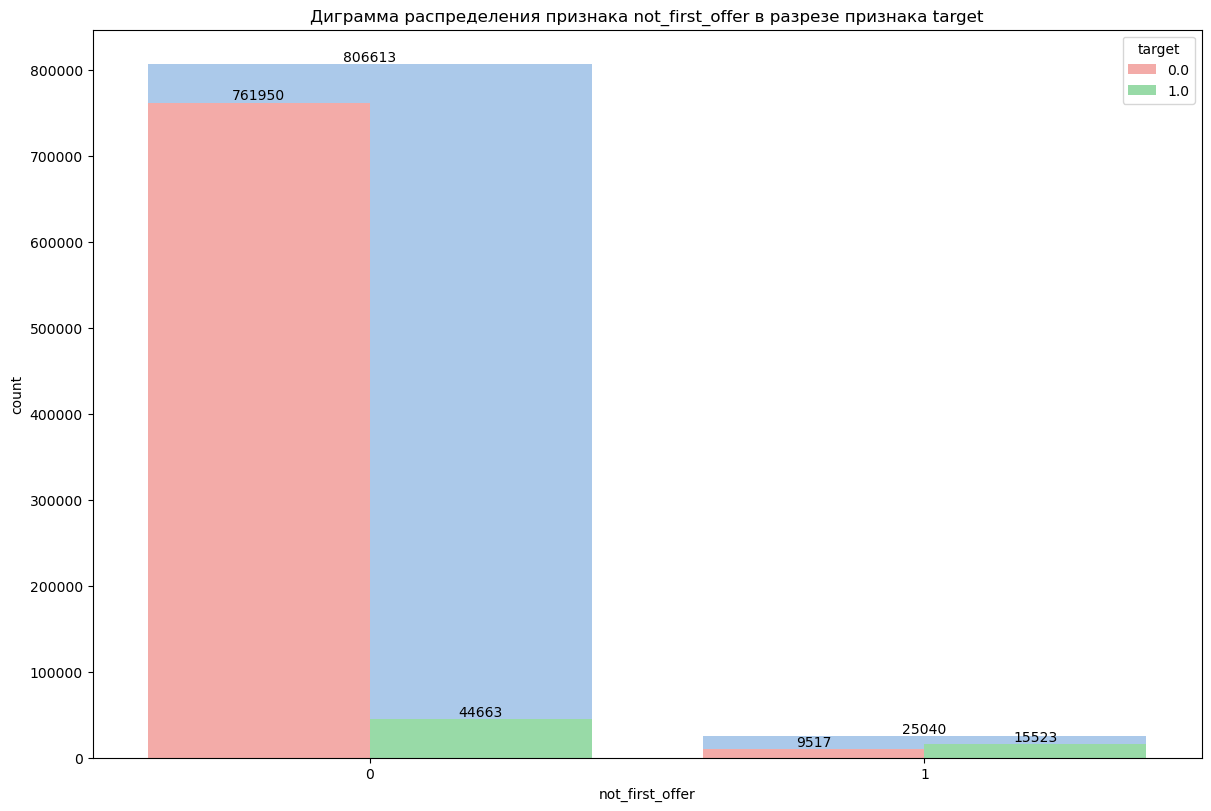

In [41]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='not_first_offer',
    hue='target',
    is_log=False,
    is_label=True
)

In [42]:
# таблица распределения частот
count_table(
    df=df_train_extended,
    feature='not_first_offer',
    target='target'
)

target            sum
target              0.0    1.0        
not_first_offer                       
0                761950  44663  806613
1                  9517  15523   25040
sum              771467  60186  831653

In [43]:
# таблица распределения относительных частот
spec_count_table(
    df=df_train_extended,
    feature='not_first_offer',
    target='target'
)

target           sum
target                0.0       1.0    
not_first_offer                        
0                0.944629  0.055371   1
1                0.380072  0.619928   1

< Примечание > Как видно из представленных данных, доля абонентов, совершивших покупку при первом предложении, гораздо меньше, чем доля абонентов, которым было осуществлено большее количество предложений (относительные частоты 0.06 и 0.62 соответственно). При этом, общее количество повторных предложений сделано очень мало (всего 25040 при общем количестве предложений 831653). В качестве возможной рекомендации предлагается увеличить количество повторных предложений услуг.

Исследование связи признака 'vas_id' с признаком 'not_first_offer':

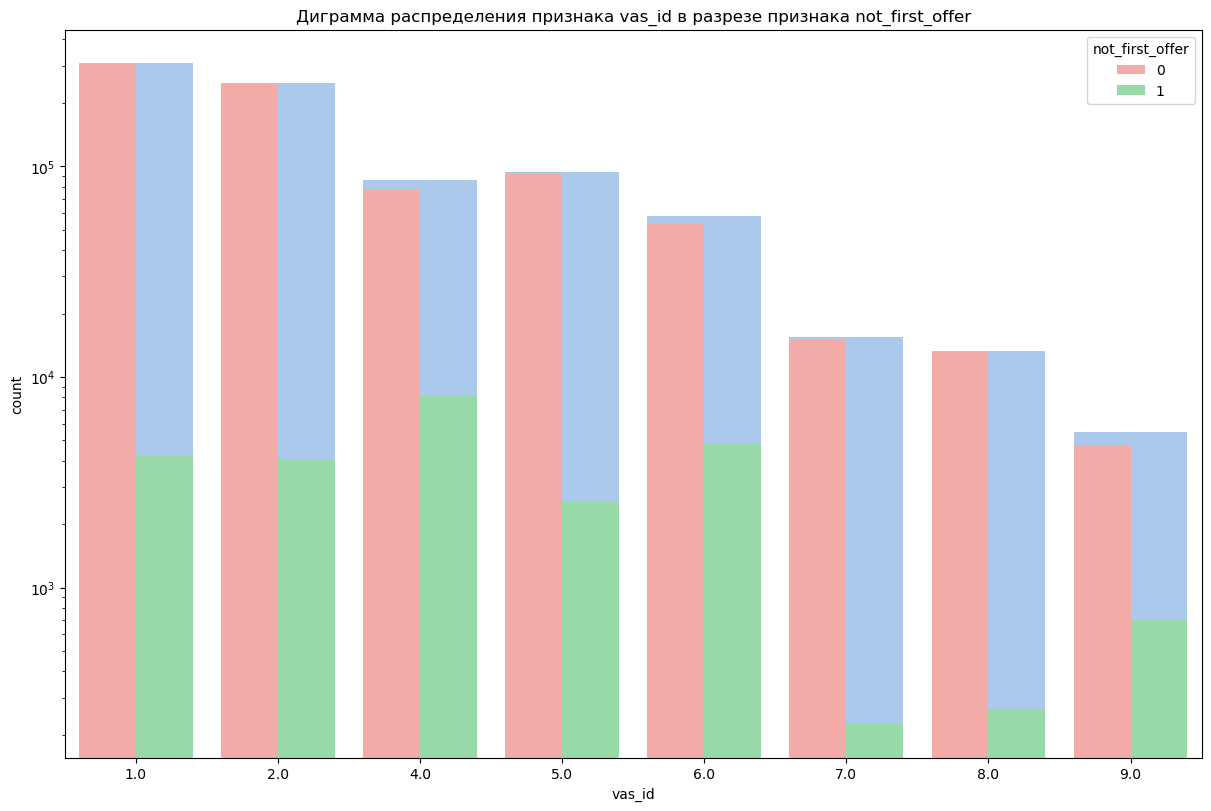

In [44]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='vas_id',
    hue='not_first_offer',
    is_log=True,
    is_label=False
)

< Примечание > Как видно из представленных данных, повторное предложение услуг 7 и 8 осуществлялось гораздо реже остальных. В качестве возможной рекомендации предлагается для данных услуг в первую очередь увеличить количество повторных предложений.

< Примечание > Признак 'not_first_offer' является бинарно-количественным с высокой несбалансированностью (количество значений 0 многократно привышает количество значений 1). Данный признак подлежит включению в список бинарных признаков.

In [45]:
nunique_2.update(['not_first_offer'])

### Анализ и предобработка признака 'vas_id'

__Анализ признака__

Обзор распределения признака:

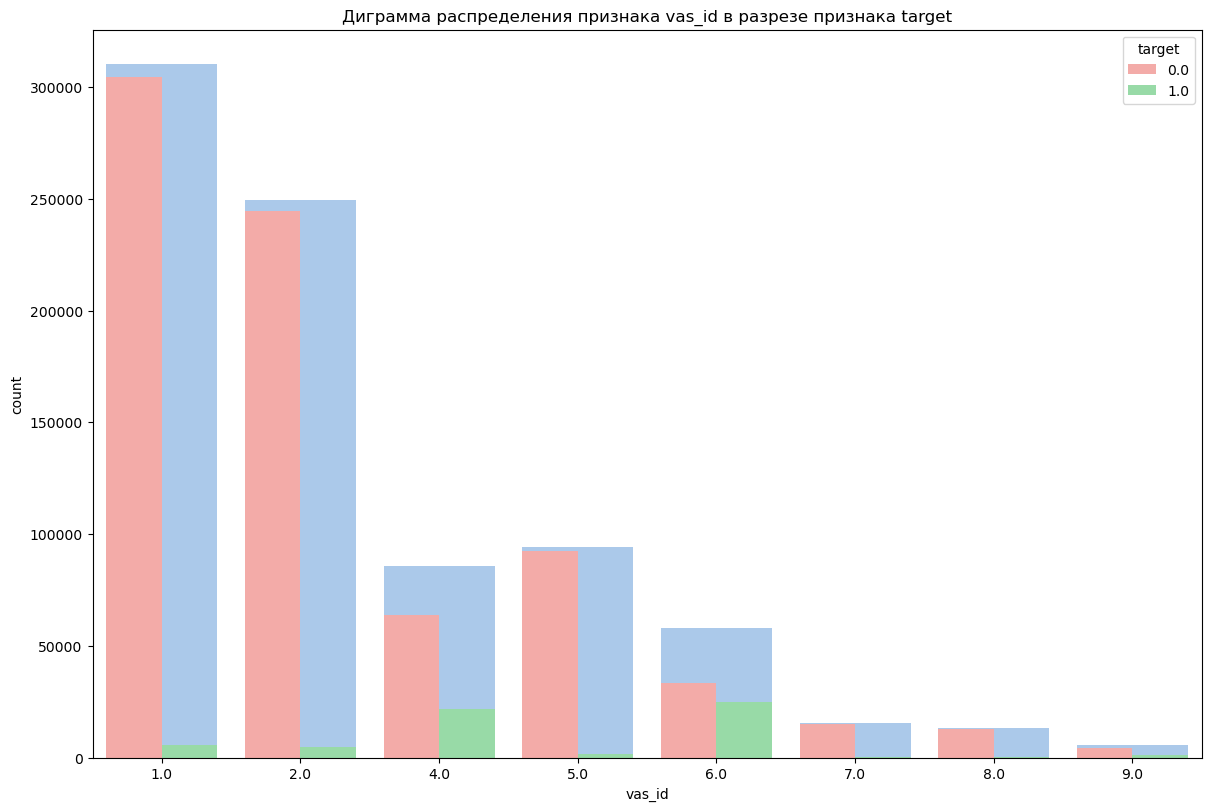

In [46]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='vas_id',
    hue='target',
    is_log=False,
    is_label=False
)

In [47]:
# таблица распределения частот
count_table(
    df=df_train_extended,
    feature='vas_id',
    target='target'
)

target            sum
target     0.0    1.0        
vas_id                       
1.0     304511   5664  310175
2.0     244708   4797  249505
4.0      63991  21765   85756
5.0      92393   1692   94085
6.0      33174  24704   57878
7.0      15219    213   15432
8.0      13003    347   13350
9.0       4468   1004    5472
sum     771467  60186  831653

In [48]:
# таблица распределения относительных частот
spec_count_table(
    df=df_train_extended,
    feature='vas_id',
    target='target'
)

target           sum
target       0.0       1.0    
vas_id                        
1.0     0.981739  0.018261   1
2.0     0.980774  0.019226   1
4.0     0.746199  0.253801   1
5.0     0.982016  0.017984   1
6.0     0.573171  0.426829   1
7.0     0.986198  0.013802   1
8.0     0.974007  0.025993   1
9.0     0.816520  0.183480   1

< Примечание > Как видно из представленных данных, услуги 4, 6 и 9 пользовались относительно большим успехом у абонентов, т.к. они чаще всего подключались (относительные частоты 0.25, 0.43 и 0.18 соответственно). При этом, в сравнении с услугами 4 и 6, услуга 9 гораздо реже предлагалась абонентам - всего 5472 раз, в то время как услуги 4 и 6 - 85756 и 57878 соответственно. Услуги 1 и 2 чаще остальных предлагались абонентам, однако, они не пользовались успехом (относительные частоты составили менее 0.02). В качестве возможной рекомендации предлагается увеличить количество предложений по услугам 4, 6 и 9, а по услугам 1 и 2 - повысить качество предложений.

< Примечание > Признак 'vas_id' является дискретно-количественным. Рекомендуется осуществить кодирование данного признака.

__Кодирование__

Трансформер кодирования методом One Hot Encoding:

In [49]:
vas_id_OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

Трансформация:

In [50]:
df_train_extended = feature_transformer(
    dataset=df_train_extended,
    source_list=['vas_id'],
    feature_name='vas_id',
    transformer=vas_id_OHE,
    prefitting=True
)

### Анализ признака 'buy_time'

__Анализ признака__

< Примечание > Приедполагается, что первоначальный признак 'buy_time' не имеет явной логической связи с целевой переменной и поэтому не принимается для моделирования. Данный признак исключается из датасетов. При этом из экземпляров признака 'buy_time' могут быть извлечены данные, которые можно использовать для создания новых признаков: год ('buy_year'), месяц ('buy_month'), день недели ('buy_isoweekday') и час ('buy_hour') совершения покупки.

In [51]:
features_to_drop = ['buy_time']
drop_list.update(features_to_drop)

### Создание, анализ и предобработка признака 'buy_year'

__Создание признака__

In [52]:
buy_year_train = pd.to_datetime(df_train_extended['buy_time'], unit='s').dt.year
df_train_extended.insert(loc=0, column='buy_year', value=buy_year_train)

__Анализ признака__

Обзор распределения признака:

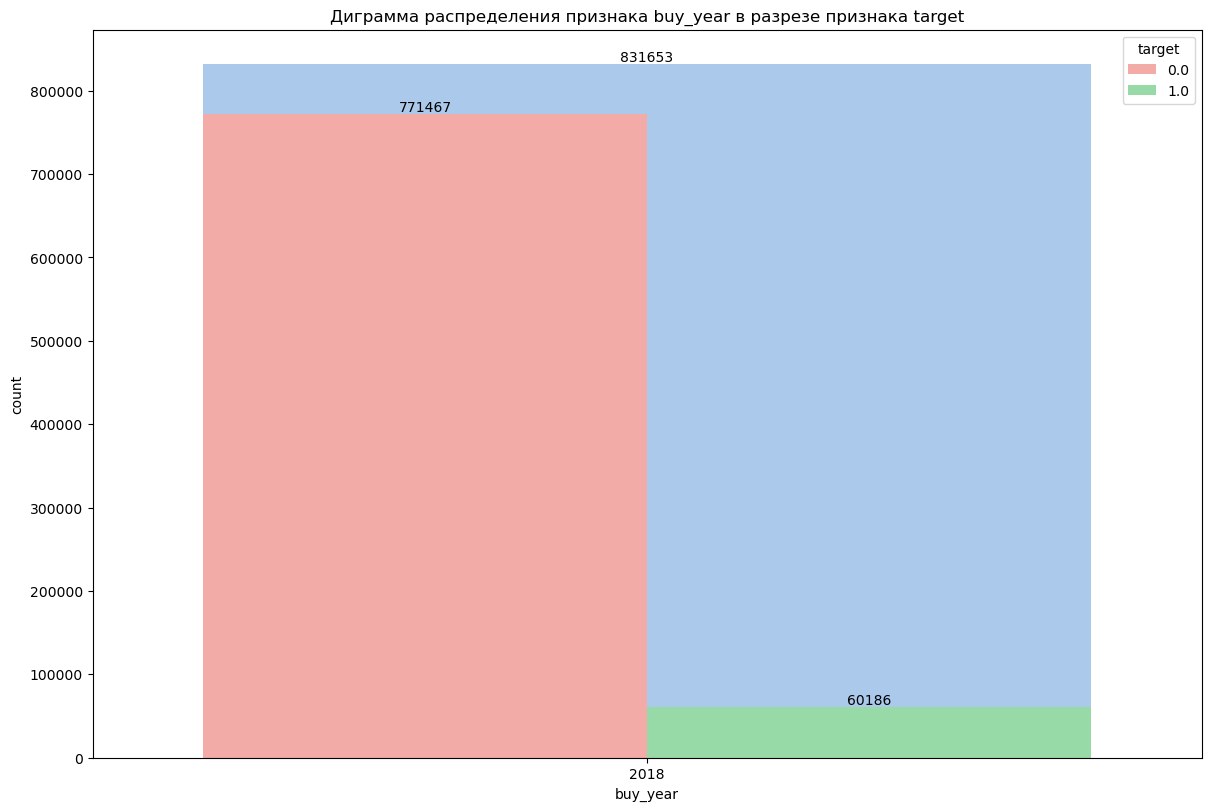

In [53]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='buy_year',
    hue='target',
    is_log=False,
    is_label=True
)

< Примечние > Признак 'buy_year' содержит единственное уникальное значение - все данные тренировочного датасета относятся только к 2018 году, поэтому данный признак не обладает прогностической ценостью и предлагается к исключению.

In [54]:
features_to_drop = ['buy_year']
drop_list.update(features_to_drop)

### Создание, анализ и предобработка признака 'buy_month'

__Создание признака__

In [55]:
buy_month_train = pd.to_datetime(df_train_extended['buy_time'], unit='s').dt.month
df_train_extended.insert(loc=0, column='buy_month', value=buy_month_train)

__Анализ признака__

Обзор распределения признака:

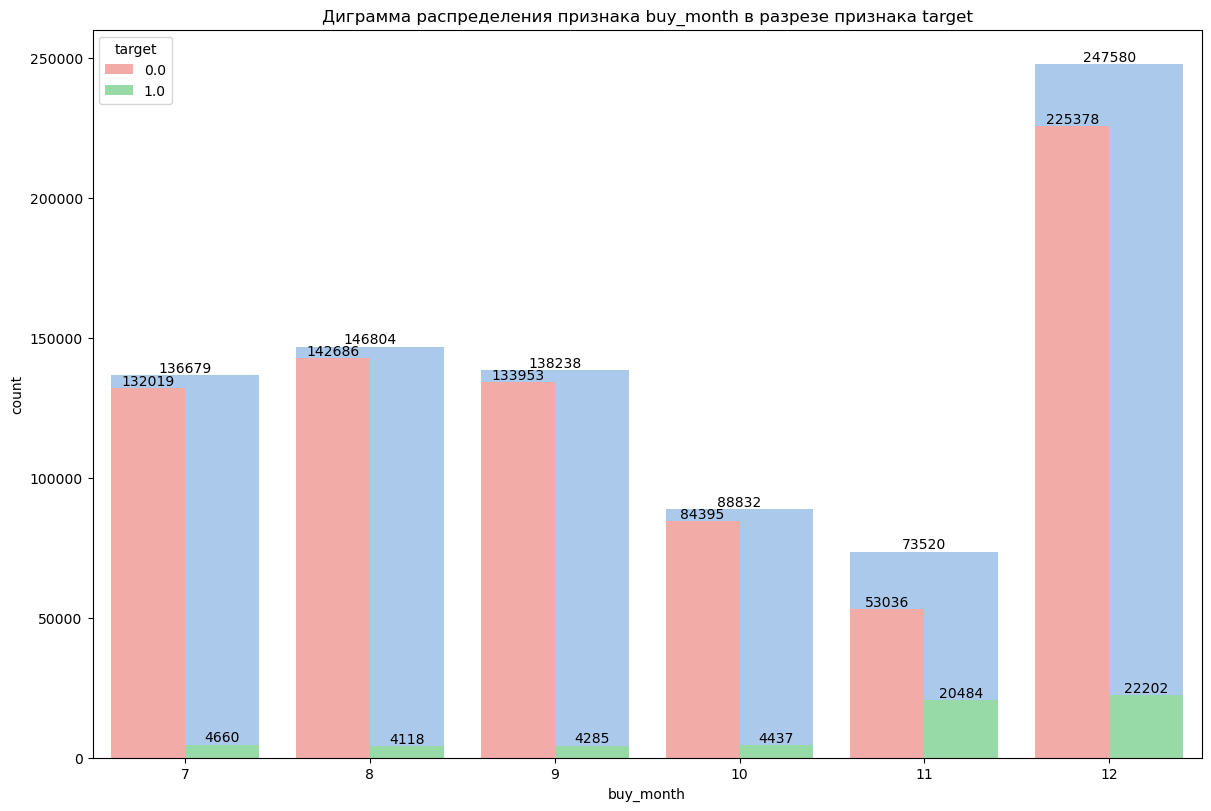

In [56]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='buy_month',
    hue='target',
    is_log=False,
    is_label=True
)

In [57]:
# таблица распределения частот
count_table(
    df=df_train_extended,
    feature='buy_month',
    target='target'
)

target            sum
target        0.0    1.0        
buy_month                       
7          132019   4660  136679
8          142686   4118  146804
9          133953   4285  138238
10          84395   4437   88832
11          53036  20484   73520
12         225378  22202  247580
sum        771467  60186  831653

In [58]:
# таблица распределения относительных частот
spec_count_table(
    df=df_train_extended,
    feature='buy_month',
    target='target'
)

target           sum
target          0.0       1.0    
buy_month                        
7          0.965906  0.034094   1
8          0.971949  0.028051   1
9          0.969003  0.030997   1
10         0.950052  0.049948   1
11         0.721382  0.278618   1
12         0.910324  0.089676   1

< Примечание > Как видно из представленных данных, ноябрь ('buy_month' = 11) отличается гораздо большей относительной частотой подключения  - 0.28, в то время, как относительные частоты подключения в другие месяцы не превышали 0.09. При этом, количество предложений в ноябре оказалось самым низким. Поскольку отсутствуют данные за другие годы, то не представляется возможность сделать выводы о наличии месячной закономерности. В качестве возможной рекомендации предлагается увеличить количество предложений в ноябре.

< Примечание > Признак 'buy_month' является дискретно-количественным. Рекомендуется осуществить кодирование данного признака.

__Кодирование__

Трансформер кодирования методом One Hot Encoding:

In [59]:
buy_month_OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

Трансформация:

In [60]:
df_train_extended = feature_transformer(
    dataset=df_train_extended,
    source_list=['buy_month'],
    feature_name='buy_month',
    transformer=buy_month_OHE,
    prefitting=True
)

### Создание, анализ и предобработка признака 'buy_weekday'

__Создание признака__

In [61]:
buy_weekday_train = pd.to_datetime(df_train_extended['buy_time'], unit='s').dt.weekday
df_train_extended.insert(loc=0, column='buy_weekday', value=buy_weekday_train)

__Анализ признака__

Обзор распределения признака:

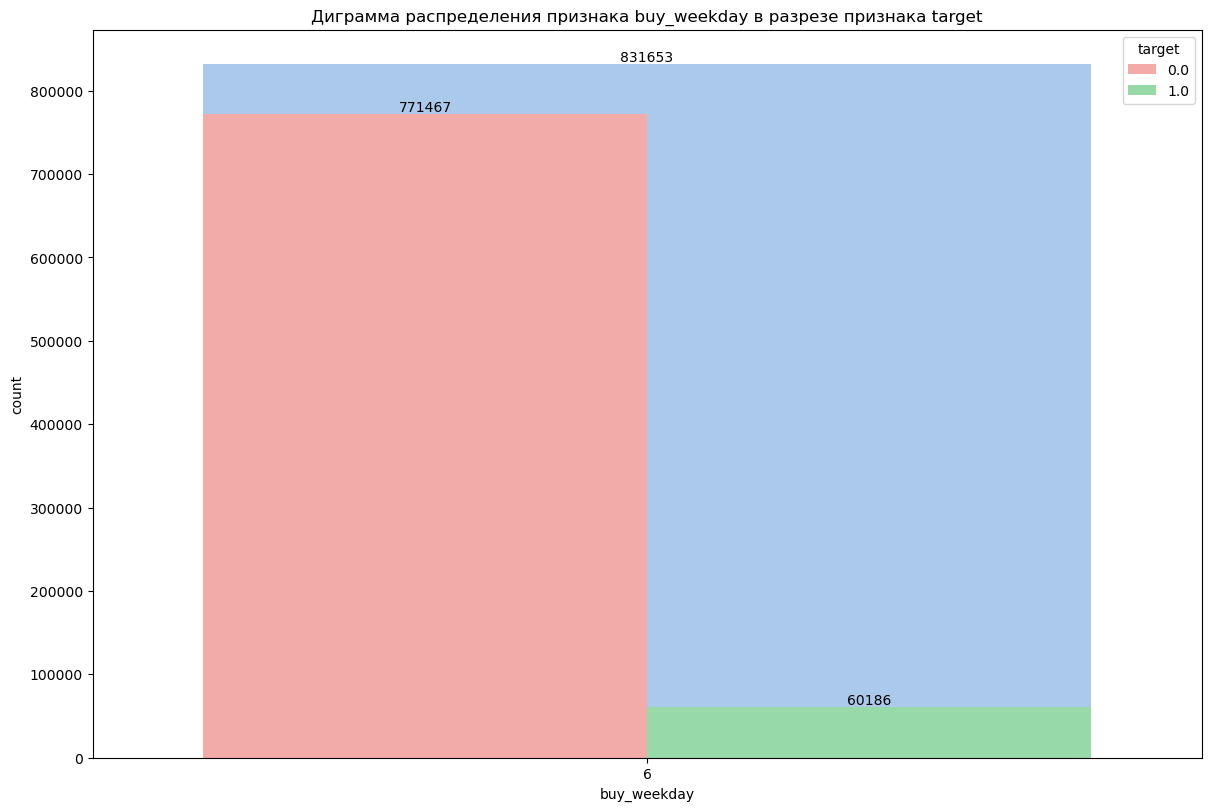

In [62]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='buy_weekday',
    hue='target',
    is_log=False,
    is_label=True
)

< Примечние > Признак 'buy_weekday' содержит единственное уникальное значение - все данные тренировочного датасета относятся только к воскресенью (значение 6), поэтому данный признак не обладает прогностической ценостью и предлагается к исключению.

In [63]:
features_to_drop = ['buy_weekday']
drop_list.update(features_to_drop)

### Создание, анализ и предобработка признака 'buy_hour'

__Создание признака__

In [64]:
buy_hour_train = pd.to_datetime(df_train_extended['buy_time'], unit='s').dt.hour
df_train_extended.insert(loc=0, column='buy_hour', value=buy_hour_train)

__Анализ признака__

Обзор распределения признака:

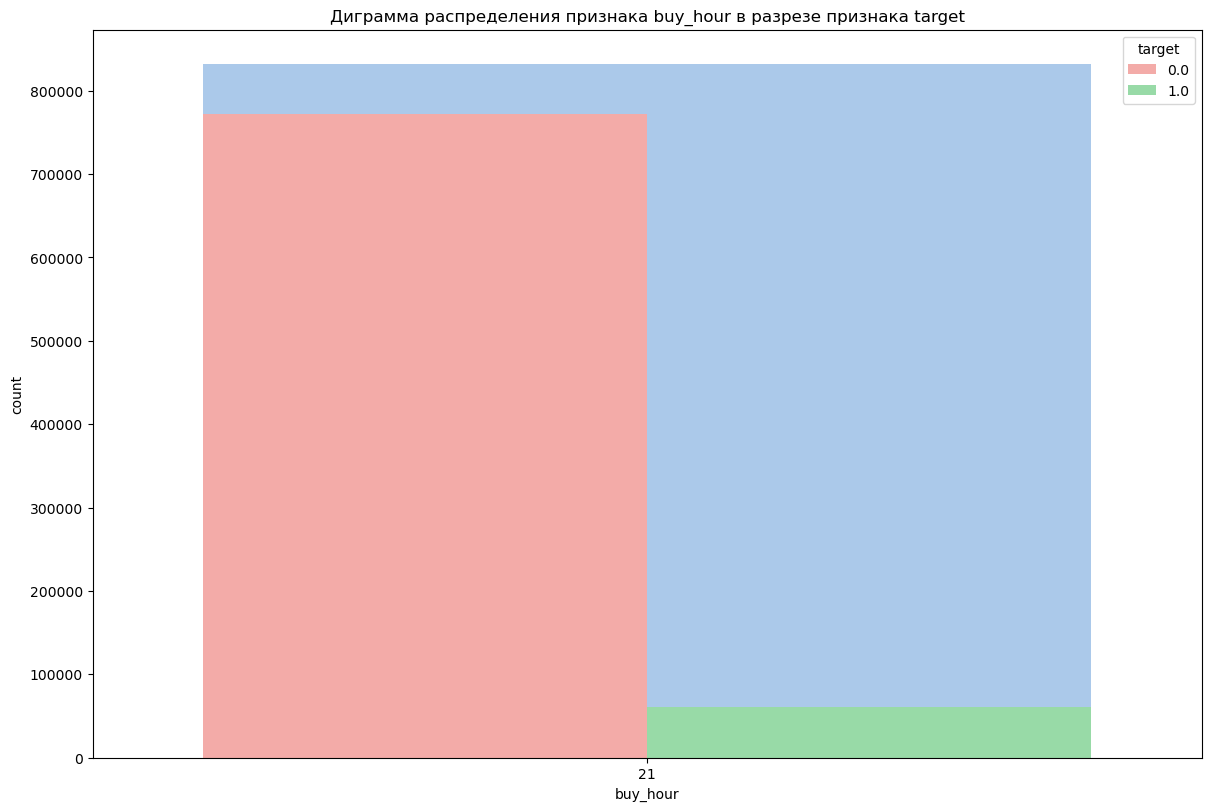

In [65]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='buy_hour',
    hue='target',
    is_log=False,
    is_label=False
)

< Примечние > Признак 'buy_hour' содержит единственное уникальное значение - все данные тренировочного датасета относятся только к 21 часу, поэтому данный признак не обладает прогностической ценостью и предлагается к исключению.

In [66]:
features_to_drop = ['buy_hour']
drop_list.update(features_to_drop)

### Анализ признака 'target' (целевая переменная)

Обзор распределения признака:

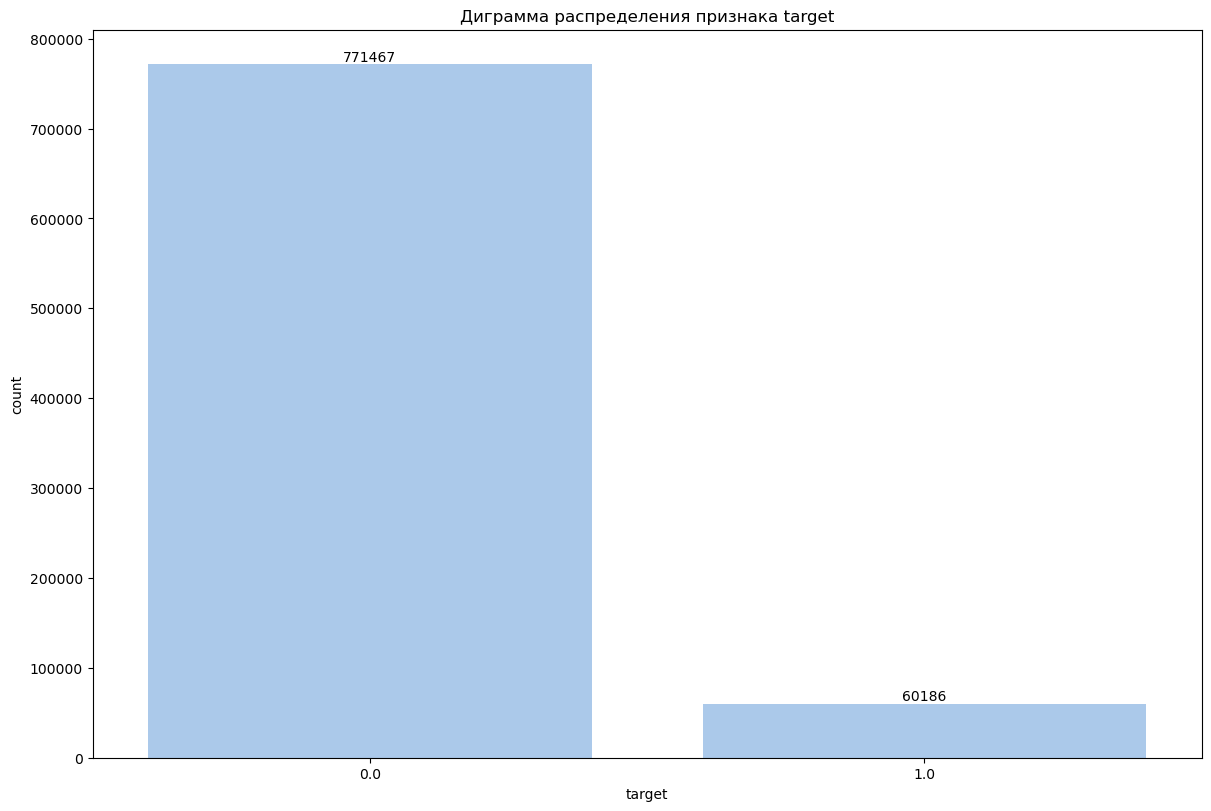

In [67]:
# диаграмма распределения
distribution_diagram(
    data=df_train_extended,
    feature_name='target',
    hue=False,
    is_log=False,
    is_label=True
)

In [68]:
# таблица распределения частот
count_table(
    df=df_train_extended,
    feature='target',
    target='target'
)

,count
target,
0,771467
1,60186
sum,831653


In [69]:
# таблица распределения относительных частот
spec_count_table(
    df=df_train_extended,
    feature='target',
    target='target'
)

,fraction
target,
0,0.927631
1,0.072369
sum,1.000000


< Примечание > Целевая переменная 'target' является бинарно-количественным признаком с высокой несбалансированностью (количество значений 0 многократно привышает количество значений 1). Для обеспечения лучшей сбалансированности при валидации моделей предлагается использовать использовать стратиграфированные валидационные выборки (например, метод "Repeated Stratified KFold"). 

### Кодирование бинарных признаков

Список бинарных признаков:

In [70]:
nunique_2 = list(nunique_2)
nunique_2

['132',
 '195',
 '33',
 '26',
 '57',
 '27',
 '192',
 '206',
 '32',
 '196',
 '204',
 '197',
 '200',
 'target',
 '198',
 'not_first_offer',
 '194',
 '201',
 '205',
 '202',
 '31',
 '199']

Сериализация списка бинарных признаков:

In [71]:
with open(r'tools/nunique_2.pickle', 'wb') as f:
    pickle.dump(nunique_2, f, protocol=pickle.HIGHEST_PROTOCOL)

Трансформер кодирования методом Ordinal Encoding:

In [72]:
nunique_2_OE = OrdinalEncoder()

Трансформация:

In [73]:
df_train_extended[nunique_2] = nunique_2_OE.fit_transform(X=df_train_extended[nunique_2])

## 6 Подготовка матрицы признаков и вектора целевой переменной к моделированию

Матрица признаков:

In [74]:
X_train = df_train_extended.copy()

Исключение признаков, подлежащих удалению:

In [75]:
drop_list = list(drop_list)

In [76]:
X_train.drop(labels=drop_list, axis=1, inplace=True, errors='ignore')

Оптимизация типов данных в матрице признаков:

In [77]:
X_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 264 entries, not_first_offer to buy_month_12
dtypes: float64(264)
memory usage: 1.6 GB


< Примечание > Все признаки имеют тип float64. При этом значения некоторых бинарных признаков равны 0 или 1. Таким образом, тип данных признаков может быть преобразован в int8, который требует меньших ресурсов памяти.

In [78]:
X_train[list(nunique_2)] = X_train[list(nunique_2)].astype('int8')

In [79]:
X_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Columns: 264 entries, not_first_offer to buy_month_12
dtypes: float64(242), int8(22)
memory usage: 1.5 GB


Созднание вектора целевой переменной (y):

In [80]:
y = X_train['target'].copy()

Исключение целевой переменной из матрицы признаков:

In [81]:
X_train.drop(labels='target', axis=1, inplace=True, errors='ignore')

Получение нормализованной матрицы признаков:

In [82]:
normalizer = MinMaxScaler(clip=True)

In [83]:
X_train_normalized = pd.DataFrame(
    normalizer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

## 7 Модельные исследования

### Вспомогательные структуры

In [84]:
def roc_auc_plot(y, y_proba):
    """Построение ROC-кривой."""

    # рассчитываем ROC-кривую и её AUC
    fpr, tpr, treshold = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # строим график
    plt.plot(
        fpr, tpr, color='darkorange',
        label='ROC кривая (AUC = %0.2f)' % roc_auc
    )
    plt.plot(
        [0, 1],
        [0, 1],
        color='navy',
        linestyle='--'
    )
    plt.xlim(
        [0.0, 1.0]
    )
    plt.ylim(
        [0.0, 1.05]
    )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Кривая ROC и её AUC')
    plt.legend(loc="lower right")
    plt.show()

In [85]:
def pr_auc_plot(y, y_proba):
    """Построение PR-кривой."""

    # рассчитываем PR-кривую и её AUC
    precision, recall, treshold = precision_recall_curve(y, y_proba)
    pr_auc = auc(recall, precision)
    
    # строим график
    plt.plot(
        recall, precision, color='darkorange',
        label='PR кривая (AUC = %0.2f)' % pr_auc
    )
    plt.xlim(
        [0.0, 1.0]
    )
    plt.ylim(
        [0.0, 1.05]
    )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Кривая PR и её AUC')
    plt.legend(loc="lower right")
    plt.show()

### Метод валидации моделей

In [86]:
cv_rskf = RepeatedStratifiedKFold(
    n_splits = 5,
    n_repeats=3,
    random_state=13
)

### Logistic Regression

Инициализация модели:

In [87]:
lr = LogisticRegression(random_state=13, max_iter=1000000)

< Примечание > Эффективность данной модели существенно снижается, если признаки тренировочного датасета имеют существенные различия в диапазонах значений, поэтому для её обучения будет использоваться нормализованный датасет.

Установка грид-параметров модели:

In [88]:
lr_param_grid = [
    {
        'penalty': [
            'none'
        ],
        'solver': [
            'lbfgs'
        ],
        'max_iter': [
            1000000
        ]
    },
    {
        'penalty': [
            'l2'
        ],
        'C': [
            0.001,
            0.01,
            0.1,
#             10,
#             100
        ],
        'solver': [
            'lbfgs'
        ],
        'max_iter': [
            1000000
        ]
    },
    {
        'penalty': [
            'l1',
            'l2'
        ],
        'C': [
            0.001,
            0.01,
            0.1,
#             10,
#             100
        ],
        'random_state': [
            13
        ],
        'solver': [
            'liblinear'
        ],
        'max_iter': [
            1000000
        ]
    },
]

Предварительный отбор признаков:

In [89]:
# обучение модели
lr.fit(X=X_train_normalized, y=y)

LogisticRegression(max_iter=1000000, random_state=13)

In [90]:
# выборка 30 наиболее значимых признаков
importance = abs(lr.coef_[0])
feature_names = X_train_normalized.columns
pd.DataFrame(
    data={
        'feature': feature_names,
        'importance': importance
    }
).sort_values(
    by='importance',
    ascending=False
).reset_index(
    drop=True
).head(
    n=30
)

,feature,importance
0,vas_id_6.0,2.990380
1,not_first_offer,2.955544
2,vas_id_4.0,1.564073
3,241,1.493063
4,buy_month_11,1.378185
5,vas_id_7.0,1.342443
6,68,1.268837
7,vas_id_5.0,1.180843
8,vas_id_1.0,1.032819
9,vas_id_2.0,0.996811


In [91]:
# экспертная оценка уровня значимости
threshold = 0.617962

In [92]:
# удаление лишних признаков из тренировочного датасета
lr_sfm = SelectFromModel(estimator=lr, threshold=threshold).fit(X=X_train_normalized, y=y)
indices_lr_sfm = lr_sfm.get_support(indices=True)
X_train_normalized_lr_sfm  = X_train_normalized.iloc[:, indices_lr_sfm]
X_train_normalized_lr_sfm.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   not_first_offer  831653 non-null  float64
 1   22               831653 non-null  float64
 2   65               831653 non-null  float64
 3   68               831653 non-null  float64
 4   144              831653 non-null  float64
 5   168              831653 non-null  float64
 6   185              831653 non-null  float64
 7   187              831653 non-null  float64
 8   210              831653 non-null  float64
 9   229              831653 non-null  float64
 10  241              831653 non-null  float64
 11  245              831653 non-null  float64
 12  vas_id_1.0       831653 non-null  float64
 13  vas_id_2.0       831653 non-null  float64
 14  vas_id_4.0       831653 non-null  float64
 15  vas_id_5.0       831653 non-null  float64
 16  vas_id_6.0       831653 non-null  floa

Настройка модели:

In [93]:
lr_gscv = GridSearchCV(
    estimator=lr,
    param_grid=lr_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv_rskf,
    verbose=1
)

In [94]:
%%time
lr_gscv.fit(X=X_train_normalized_lr_sfm, y=y)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
CPU times: total: 9.03 s
Wall time: 5min 30s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=13),
             estimator=LogisticRegression(max_iter=1000000, random_state=13),
             n_jobs=-1,
             param_grid=[{'max_iter': [1000000], 'penalty': ['none'],
                          'solver': ['lbfgs']},
                         {'C': [0.001, 0.01, 0.1], 'max_iter': [1000000],
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': [0.001, 0.01, 0.1], 'max_iter': [1000000],
                          'penalty': ['l1', 'l2'], 'random_state': [13],
                          'solver': ['liblinear']}],
             scoring='f1_macro', verbose=1)

Анализ модели:

In [95]:
lr_gscv.best_score_

0.6849596866110068

In [96]:
lr_gscv.best_params_

{'C': 0.01,
 'max_iter': 1000000,
 'penalty': 'l1',
 'random_state': 13,
 'solver': 'liblinear'}

In [97]:
lr_tuned = lr_gscv.best_estimator_

In [98]:
lr_tuned.fit(X=X_train_normalized_lr_sfm, y=y)
y_lr_tuned = lr_tuned.predict(X=X_train_normalized_lr_sfm)
y_lr_tuned_proba = lr_tuned.predict_proba(X=X_train_normalized_lr_sfm)[:, 1]

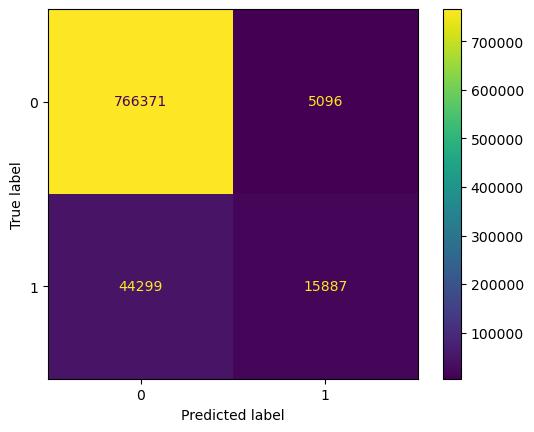

In [99]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y, y_pred=y_lr_tuned))
disp.plot();

In [100]:
print(classification_report(y_true=y, y_pred=y_lr_tuned))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    771467
           1       0.76      0.26      0.39     60186

    accuracy                           0.94    831653
   macro avg       0.85      0.63      0.68    831653
weighted avg       0.93      0.94      0.93    831653



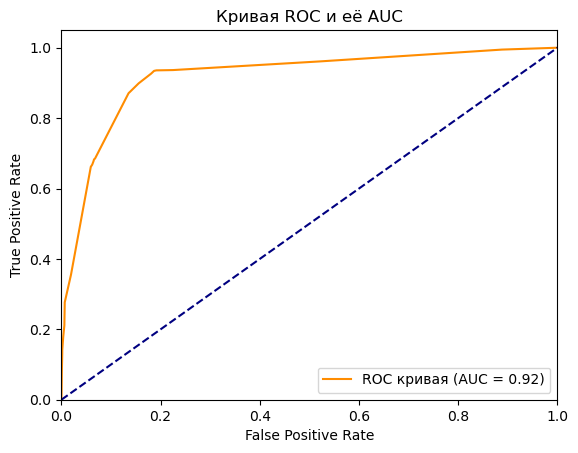

In [101]:
roc_auc_plot(y=y, y_proba=y_lr_tuned_proba)

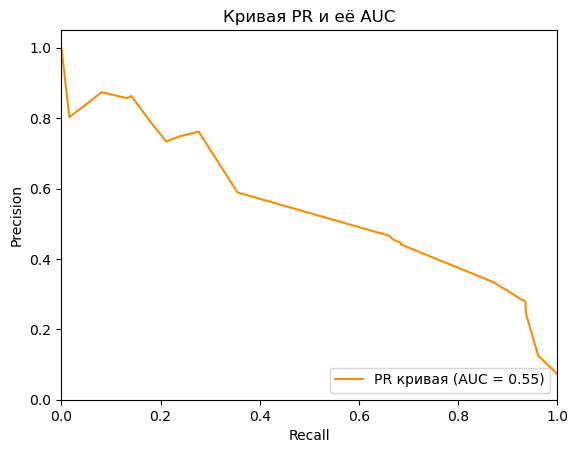

In [102]:
pr_auc_plot(y=y, y_proba=y_lr_tuned_proba)

### Decision Tree Classifier

Инициализация модели:

In [103]:
dtc = DecisionTreeClassifier(random_state=13)

< Примечание > Эффективность данной модели существенно не снижается, если признаки тренировочного датасета имеют существенные различия в диапазонах значений, поэтому для её обучения будет использоваться ненормализованный датасет.

Установка грид-параметров модели:

In [104]:
dtc_param_grid = {
    'criterion': [
        'gini',  # default
        'entropy',
#         'log_loss'
    ],
    'splitter': [
        'best',  # default
        'random'
    ],
    'max_depth': [
      None,  # default
        2,
        3,
#         4,
#         5,
#         6
    ],
    'max_features': [
        None,  # default
        'sqrt',
        'log2'
    ],
    'random_state': [
        13
    ]
}

Предварительный отбор признаков:

In [105]:
# обучение модели
dtc.fit(X=X_train, y=y)

DecisionTreeClassifier(random_state=13)

In [106]:
# выборка 30 наиболее значимых признаков
importance = abs(dtc.feature_importances_)
feature_names = X_train.columns
pd.DataFrame(
    data={
        'feature': feature_names,
        'importance': importance
    }
).sort_values(
    by='importance',
    ascending=False
).reset_index(
    drop=True
).head(
    n=30
)

,feature,importance
0,vas_id_6.0,0.140065
1,not_first_offer,0.117280
2,vas_id_4.0,0.052028
3,buy_month_11,0.045803
4,226,0.016690
5,207,0.011475
6,52,0.011333
7,164,0.011239
8,144,0.009921
9,58,0.009398


In [137]:
# экспертная оценка уровня значимости
threshold = 0.007931

In [138]:
# удаление лишних признаков из тренировочного датасета
dtc_sfm = SelectFromModel(estimator=dtc, threshold=threshold).fit(X=X_train, y=y)
indices_dtc_sfm = dtc_sfm.get_support(indices=True)
X_train_dtc_sfm  = X_train.iloc[:, indices_dtc_sfm]
X_train_dtc_sfm.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   not_first_offer  831653 non-null  int8   
 1   1                831653 non-null  float64
 2   5                831653 non-null  float64
 3   52               831653 non-null  float64
 4   53               831653 non-null  float64
 5   58               831653 non-null  float64
 6   61               831653 non-null  float64
 7   64               831653 non-null  float64
 8   114              831653 non-null  float64
 9   115              831653 non-null  float64
 10  128              831653 non-null  float64
 11  144              831653 non-null  float64
 12  145              831653 non-null  float64
 13  164              831653 non-null  float64
 14  207              831653 non-null  float64
 15  226              831653 non-null  float64
 16  229              831653 non-null  floa

Настройка модели:

In [139]:
dtc_gscv = GridSearchCV(
    estimator=dtc,
    param_grid=dtc_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv_rskf,
    verbose=1
)

In [140]:
%%time
dtc_gscv.fit(X=X_train_dtc_sfm, y=y)

Fitting 15 folds for each of 36 candidates, totalling 540 fits
CPU times: total: 35.7 s
Wall time: 5min 58s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=13),
             estimator=DecisionTreeClassifier(random_state=13), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3],
                         'max_features': [None, 'sqrt', 'log2'],
                         'random_state': [13], 'splitter': ['best', 'random']},
             scoring='f1_macro', verbose=1)

Анализ модели:

In [141]:
dtc_gscv.best_score_

0.6743793576487231

In [142]:
dtc_gscv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'random_state': 13,
 'splitter': 'best'}

In [143]:
dtc_tuned = dtc_gscv.best_estimator_

In [144]:
dtc_tuned.fit(X=X_train_dtc_sfm, y=y)
y_dtc_tuned = dtc_tuned.predict(X=X_train_dtc_sfm)
y_dtc_tuned_proba = dtc_tuned.predict_proba(X=X_train_dtc_sfm)[:, 1]

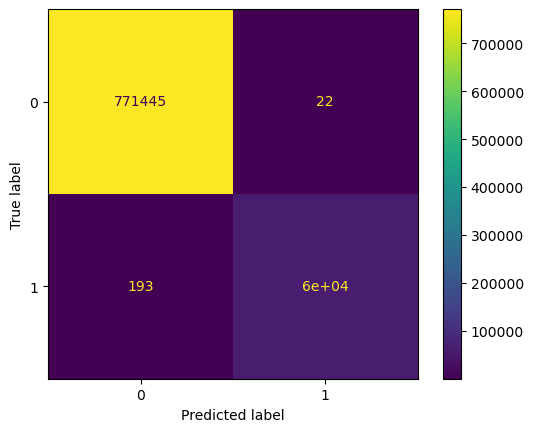

In [145]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y, y_pred=y_dtc_tuned))
disp.plot();

In [146]:
print(classification_report(y_true=y, y_pred=y_dtc_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    771467
           1       1.00      1.00      1.00     60186

    accuracy                           1.00    831653
   macro avg       1.00      1.00      1.00    831653
weighted avg       1.00      1.00      1.00    831653



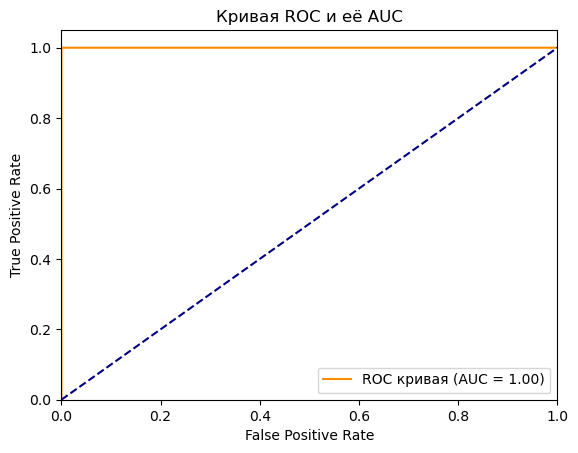

In [147]:
roc_auc_plot(y=y, y_proba=y_dtc_tuned_proba)

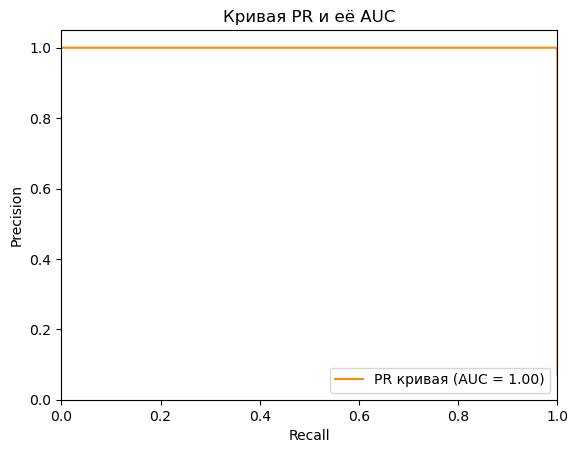

In [148]:
pr_auc_plot(y=y, y_proba=y_dtc_tuned_proba)

### XGBoost Classifier

Инициализация модели:

In [119]:
xgbc = XGBClassifier(random_state=13, n_jobs=-1)

< Примечание > Эффективность данной модели существенно не снижается, если признаки тренировочного датасета имеют существенные различия в диапазонах значений, поэтому для её обучения будет использоваться ненормализованный датасет.

Установка грид-параметров модели:

In [120]:
xgbc_param_grid = {
    'colsample_bytree': [
        0.5,
        1  # default
    ],    
    'learning_rate': [
#         0.1,
        0.3,  # default
#         0.6,
    ],   
    'max_depth': [
        3,
        6,  # default
#         9,
#         12,
#         15,
#         18,
#         21,
#         24,
#         27,
#         30,
#         33,
#         None
    ],
    'n_estimators': [
        50,
        100,  # default
#         200
    ],
    'n_jobs': [
        -1
    ],
    'random_state': [
        13
    ],
    'reg_alpha': [
        0,  # default
        0.5,
#         1,
    ],
    'reg_lambda': [
#         0,
        0.5,
        1 # default
    ],
    'subsample': [
#         0.5,
        1  # default
    ],
}

Предварительный отбор признаков:

In [121]:
# обучение модели
xgbc.fit(X=X_train, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=13, ...)

In [122]:
# выборка 30 наиболее значимых признаков
importance = abs(xgbc.feature_importances_)
feature_names = X_train.columns
pd.DataFrame(
    data={
        'feature': feature_names,
        'importance': importance
    }
).sort_values(
    by='importance',
    ascending=False
).reset_index(
    drop=True
).head(
    n=30
)

,feature,importance
0,vas_id_6.0,0.361678
1,vas_id_4.0,0.304153
2,not_first_offer,0.057511
3,buy_month_11,0.050183
4,vas_id_2.0,0.023589
5,vas_id_5.0,0.019834
6,vas_id_1.0,0.011562
7,vas_id_7.0,0.006425
8,buy_month_12,0.005869
9,buy_month_10,0.004008


In [123]:
# экспертная оценка уровня значимости
threshold = 0.000949

In [124]:
# удаление лишних признаков из тренировочного датасета
xgbc_sfm = SelectFromModel(estimator=xgbc, threshold=threshold).fit(X=X_train, y=y)
indices_xgbc_sfm = xgbc_sfm.get_support(indices=True)
X_train_xgbc_sfm  = X_train.iloc[:, indices_xgbc_sfm]
X_train_xgbc_sfm.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   not_first_offer  831653 non-null  int8   
 1   72               831653 non-null  float64
 2   93               831653 non-null  float64
 3   150              831653 non-null  float64
 4   152              831653 non-null  float64
 5   196              831653 non-null  int8   
 6   vas_id_1.0       831653 non-null  float64
 7   vas_id_2.0       831653 non-null  float64
 8   vas_id_4.0       831653 non-null  float64
 9   vas_id_5.0       831653 non-null  float64
 10  vas_id_6.0       831653 non-null  float64
 11  vas_id_7.0       831653 non-null  float64
 12  vas_id_8.0       831653 non-null  float64
 13  vas_id_9.0       831653 non-null  float64
 14  buy_month_7      831653 non-null  float64
 15  buy_month_8      831653 non-null  float64
 16  buy_month_9      831653 non-null  floa

Настройка модели:

In [125]:
xgbc_gscv = GridSearchCV(
    estimator=xgbc,
    param_grid=xgbc_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv_rskf,
    verbose=1
)

In [126]:
%%time
xgbc_gscv.fit(X=X_train_xgbc_sfm, y=y)

Fitting 15 folds for each of 32 candidates, totalling 480 fits
CPU times: total: 2min 5s
Wall time: 40min 11s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=13),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_...
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1], 'learning_rate': [0.3],
                         'max_depth': [3, 6], 'n_estimators': [50, 100],
                         'n_jobs': [-1], 'random_state': [13],
                         'reg_alpha': [0, 0.5], 'reg_lambda': [0.5, 1],
                         'subsample': [1]},
             scoring='f1_macro', verbose=1)

Анализ модели:

In [127]:
xgbc_gscv.best_score_

0.685645790195694

In [128]:
xgbc_gscv.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 13,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'subsample': 1}

In [129]:
xgbc_tuned = xgbc_gscv.best_estimator_

In [130]:
xgbc_tuned.fit(X=X_train_xgbc_sfm, y=y)
y_xgbc_tuned = xgbc_tuned.predict(X=X_train_xgbc_sfm)
y_xgbc_tuned_proba = xgbc_tuned.predict_proba(X=X_train_xgbc_sfm)[:, 1]

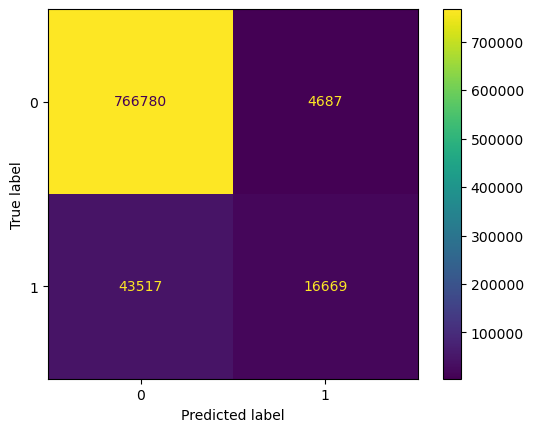

In [131]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y, y_pred=y_xgbc_tuned))
disp.plot();

In [132]:
print(classification_report(y_true=y, y_pred=y_xgbc_tuned))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    771467
           1       0.78      0.28      0.41     60186

    accuracy                           0.94    831653
   macro avg       0.86      0.64      0.69    831653
weighted avg       0.93      0.94      0.93    831653



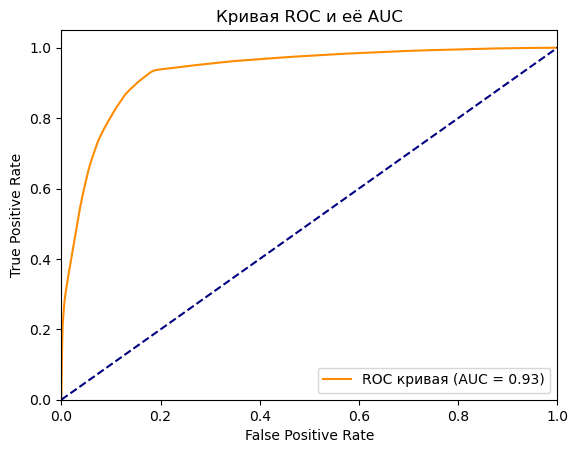

In [133]:
roc_auc_plot(y=y, y_proba=y_xgbc_tuned_proba)

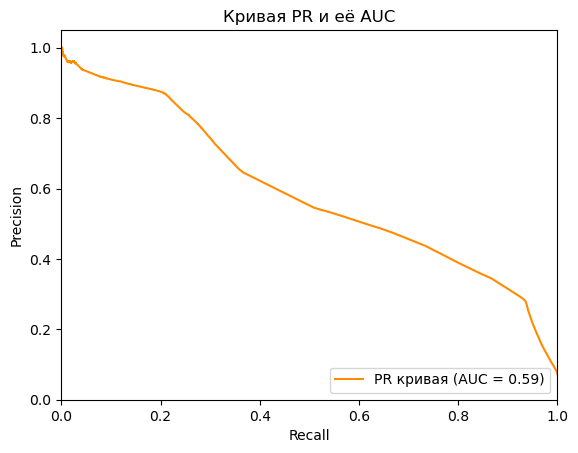

In [134]:
pr_auc_plot(y=y, y_proba=y_xgbc_tuned_proba)

< Примечание > Исходя из полученных результатов, наилучей из исследованных моделей оказалась модель XGBoost Classifier, которая показала самую высокую метрику на кросс-валидации. Данная модель принята для осуществления предсказаний.

## 8 Получение финального результата

Сериализация списка отобранных признаков принятой модели:

In [135]:
selected_features = list(X_train_xgbc_sfm.columns)

In [136]:
with open(r'tools/selected_features.pickle', 'wb') as f:
    pickle.dump(selected_features, f, protocol=pickle.HIGHEST_PROTOCOL)